# Prelude

In [1]:
import numpy as np
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gmt = ceo.GMT_MX()

# On-axis NGS 

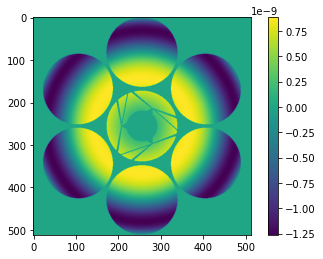

In [3]:
ngs = ceo.Source("V",rays_box_size=25.5,rays_box_sampling=512)
ngs>>(gmt,)
+ngs
fig,ax = plt.subplots()
h = ax.imshow(ngs.phase.host())
fig.colorbar(h,ax=ax)

# Off-axis NGS

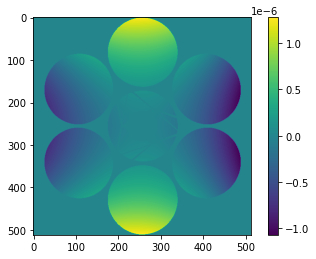

In [4]:
ngs_oa = ceo.Source("V",zenith=3*ceo.constants.ARCMIN2RAD,azimuth=0,rays_box_size=25.5,rays_box_sampling=512)
ngs_oa>>(gmt,)
+ngs_oa
fig,ax = plt.subplots()
h = ax.imshow(ngs_oa.phase.host())
fig.colorbar(h,ax=ax)

# On-axis Laser Guide Star

In [5]:
lgs = ceo.Source("V",height=90e3,rays_box_size=25.5,rays_box_sampling=512)
lgs>>(gmt,)
+lgs

In [6]:
# thin lens formula
focal_length = 207588.8e-3
S1 = 90e3
S2 = 1./(1./focal_length-1./S1)
delta = S2 - focal_length
S1,S2, delta

(90000.0, 208.0687192861572, 0.47991928615721235)

In [7]:
# Zernike focus coefficients
wavelength = 0.5e-6
diameter = 25.5
a4 = delta / ( 16*np.sqrt(3)*( (focal_length/diameter)**2 + focal_length*delta/diameter**2 ) )
a4

0.0002607097309309336

In [8]:
u = np.linspace(-1,1,512)
x,y = np.meshgrid(u,u)
r2 = x*x + y*y
z4 = a4*np.sqrt(3)*(2*r2-1)
s4 = z4 - np.min(z4)

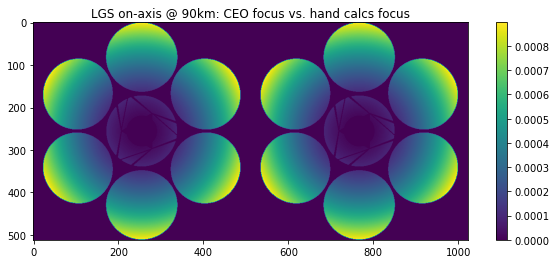

In [9]:
fig,ax = plt.subplots(figsize=(10,4))
h = ax.imshow(np.hstack([lgs.phase.host(),s4*lgs.amplitude.host() ]))
ax.set_title("LGS on-axis @ 90km: CEO focus vs. hand calcs focus")
fig.colorbar(h,ax=ax)

# Off-axis Laser Guide Star

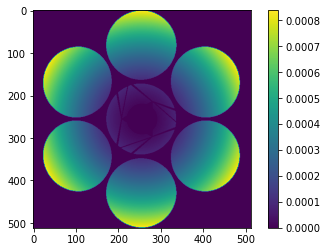

In [10]:
lgs_oa = ceo.Source("V",zenith=3*ceo.constants.ARCMIN2RAD,azimuth=0,height=90e3,rays_box_size=25.5,rays_box_sampling=512)
lgs_oa>>(gmt,)
+lgs_oa
fig,ax = plt.subplots()
h = ax.imshow(lgs_oa.phase.host())
fig.colorbar(h,ax=ax)

# Zernike fittiing

In [11]:
Z = ceo.ZernikeS(4) # 4 is the largest radial order, so # of modes is 5*6/2=15
Z.a.shape

(1, 15)

In [12]:
npx = 512
u = np.linspace(-1,1,npx)
x,y = np.meshgrid(u,u, indexing = "xy")
r = np.hypot(x,y)
P = r<=1
o = np.arctan2(y,x)
cuo = ceo.cuDoubleArray(host_data=o)
cur = ceo.cuDoubleArray(host_data=r)

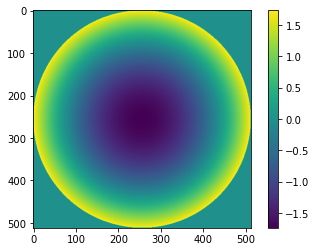

In [13]:
Z.a[...] = 0
Z.a[0,3] = 1
Z.update()
S = Z.surface(cur,cuo)
plt.imshow(S.host()*P)
plt.colorbar()

In [14]:
m = lgs_oa.wavefront.amplitude.host().T>0
m.shape

(262144, 1)

In [15]:
Zmat = []
for i in range(15):
    Z.a[...] = 0
    Z.a[0,i] = 1
    Z.update()
    S = Z.surface(cur,cuo)
    Zmat += [S.host().ravel()[:,None][m]]
Zmat = np.vstack(Zmat).T
Zmat.shape

(141092, 15)

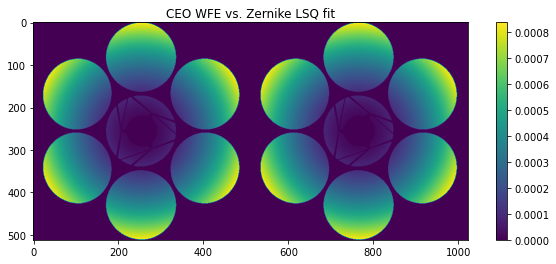

In [16]:
src = lgs_oa
a = np.linalg.lstsq(Zmat,src.wavefront.phase.host().T[m],rcond=None)[0]

Z.a[...] = a
Z.update()
S = Z.surface(cur,cuo)
fig,ax = plt.subplots(figsize=(10,4))
h = ax.imshow(np.hstack([src.phase.host(),S.host()*src.amplitude.host()]))
ax.set_title("CEO WFE vs. Zernike LSQ fit")
fig.colorbar(h,ax=ax)

In [17]:
a_ngs = np.linalg.lstsq(Zmat,ngs.wavefront.phase.host().T[m],rcond=None)[0]
a_ngs_oa = np.linalg.lstsq(Zmat,ngs_oa.wavefront.phase.host().T[m],rcond=None)[0]
a_lgs = np.linalg.lstsq(Zmat,lgs.wavefront.phase.host().T[m],rcond=None)[0]
a_lgs_oa = np.linalg.lstsq(Zmat,lgs_oa.wavefront.phase.host().T[m],rcond=None)[0]

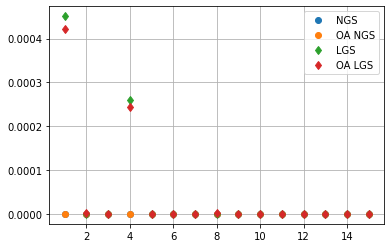

In [18]:
j = np.arange(1,16)
fig,ax = plt.subplots()
ax.plot(j,a_ngs,"C0o",label="NGS")
ax.plot(j,a_ngs_oa,"C1o",label="OA NGS")
ax.plot(j,a_lgs,"C2d",label="LGS")
ax.plot(j,a_lgs_oa,"C3d",label="OA LGS")
ax.grid()
ax.legend()

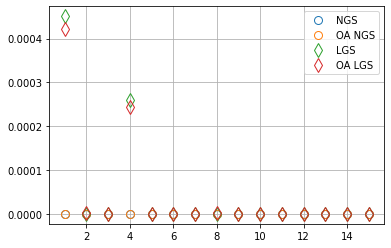

In [19]:
j = np.arange(1,16)
fig,ax = plt.subplots()
ax.plot(j,a_ngs,"o",ms=8,mfc="None",mec='C0',label="NGS")
ax.plot(j,a_ngs_oa,"o",ms=8,mfc="None",mec='C1',label="OA NGS")
ax.plot(j,a_lgs,"d",ms=10,mfc="None",mec='C2',label="LGS")
ax.plot(j,a_lgs_oa,"d",ms=10,mfc="None",mec='C3',label="OA LGS")
ax.grid()
ax.legend()

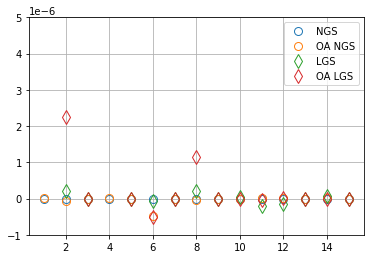

In [20]:
j = np.arange(1,16)
fig,ax = plt.subplots()
ax.plot(j,a_ngs,"o",ms=8,mfc="None",mec='C0',label="NGS")
ax.plot(j,a_ngs_oa,"o",ms=8,mfc="None",mec='C1',label="OA NGS")
ax.plot(j,a_lgs,"d",ms=10,mfc="None",mec='C2',label="LGS")
ax.plot(j,a_lgs_oa,"d",ms=10,mfc="None",mec='C3',label="OA LGS")
ax.set_ylim([-1e-6,5e-6])
ax.grid()
ax.legend()